# THETA \begin{equation*} \frac{\partial V}{\partial t} = \Psi + \Omega \end{equation*}
## **ECCO**
adapted from `poster-figs.ipynb`

In [3]:
from dask.distributed import Client

client = Client("tcp://10.32.16.235:39667")
client

Client Scheduler: tcp://10.32.16.235:39667 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 30 Cores: 60 Memory: 345.00 GB


In [4]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [5]:
xr.set_options(display_style='text')

In [6]:
coords = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/coords_wg.zarr')) #didn't upload wg region
ds_tns = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_tns.zarr'))
#ds_slt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_slt_wg.zarr'))
ds_tmp = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_tmp_wg.zarr'))
ds_vel = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_vel.zarr'))
ds = xr.merge([ds_tns, ds_tmp, ds_vel])
ds

<xarray.Dataset>
Dimensions:                  (i: 95, i_g: 96, j: 50, j_g: 51, k: 50, k_l: 50, time: 288, time_snp: 287)
Coordinates:
  * k                        (k) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * time                     (time) datetime64[ns] 1992-01-15 ... 2015-12-14
  * time_snp                 (time_snp) datetime64[ns] 1992-02-01 ... 2015-12-01
  * k_l                      (k_l) int64 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
Dimensions without coordinates: i, i_g, j, j_g
Data variables:
    SALT                     (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    SALT_snp                 (time_snp, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    THETA                    (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    THETA_snp                (time_snp, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    dt                       (time) float32 dask.array<chunksize=(288,), meta=np.ndarray>
    conv_horiz_adv_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    surface_flux_conv_TH     (k, time, j, i) float32 dask.array<chunksize=(50, 1, 50, 95), meta=np.ndarray>
    sw_flux_conv_TH          (time, j, i, k) float32 dask.array<chunksize=(1, 50, 95, 50), meta=np.ndarray>
    total_tendency_TH_truth  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    UVEL                     (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    VVEL                     (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 51, 67), meta=np.ndarray>
    WVEL                     (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>

### Checking if `rhs` and `lhs` seem to match

In [7]:
rhs_vars = [dvar for dvar in ds_tmp.data_vars
            if dvar != 'total_tendency_TH_truth']
total_tendency_check = sum([ds_tmp[dvar] for dvar in rhs_vars])
total_tendency_check

<xarray.DataArray (time: 288, k: 50, j: 50, i: 95)>
dask.array<add, shape=(288, 50, 50, 95), dtype=float32, chunksize=(1, 50, 50, 95), chunktype=numpy.ndarray>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: j, i

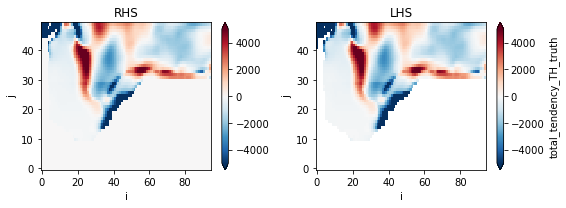

In [10]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3))
total_tendency_check[1, 0].plot(ax=ax0, robust=True, vmax=5e3)
ax0.set_title('RHS')

ds.total_tendency_TH_truth[1, 0].plot(ax=ax1, robust=True, vmax=5e3)
ax1.set_title('LHS')
plt.tight_layout();

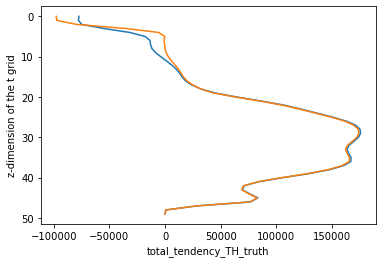

In [11]:
delta_theta = ds.THETA_snp.isel(time_snp=-1) - ds.THETA_snp.isel(time_snp=0)
total_time = (ds.time_snp[-1] - ds.time_snp[0]).astype('f8')*1e-9

vol = (coords.drF * coords.rA * coords.hFacC)
((delta_theta * vol).sum(dim=['j', 'i'])/ total_time).plot(y='k', yincrease=False)
ds.total_tendency_TH_truth.sum(dim=['j', 'i']).mean(dim='time').plot(y='k', yincrease=False)

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} == \Omega_{tottend-SLT-truth} + R1 \end{equation*} </font>

In [14]:
# define bins
delta_theta = 0.1
theta_bins = np.arange(-2, 4, delta_theta)
#define theta_bines for WG range

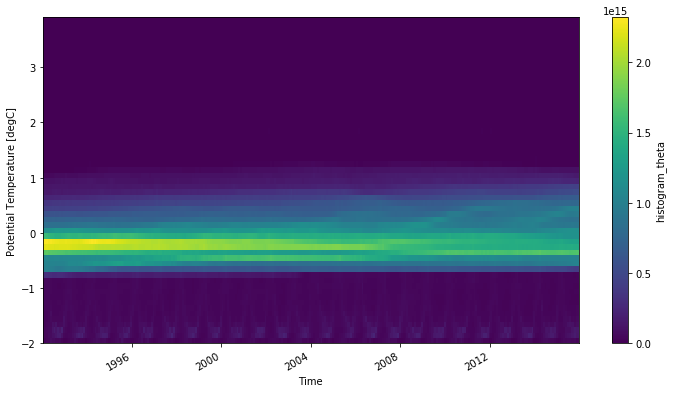

In [15]:
# theta distribution in WG region
theta_dist = histogram(ds.THETA_snp.rename('theta'), bins=[theta_bins],
                       weights=vol, dim=['i', 'j', 'k'])
theta_dist.plot(x='time_snp', figsize=(12, 6))

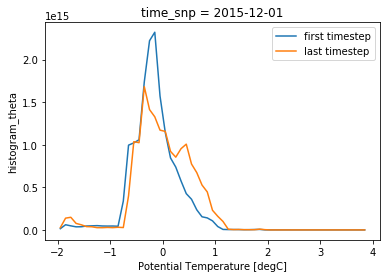

In [16]:
theta_dist[0].plot(label='first timestep')
theta_dist[-1].plot(label='last timestep')
plt.legend();

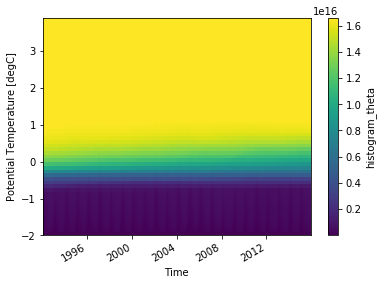

In [17]:
# cumulative volume
V = theta_dist.cumsum(dim='theta_bin')
V.transpose().plot()

In [18]:
V

<xarray.DataArray 'histogram_theta' (time_snp: 287, theta_bin: 59)>
dask.array<nancumsum, shape=(287, 59), dtype=float64, chunksize=(1, 59), chunktype=numpy.ndarray>
Coordinates:
  * time_snp   (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
  * theta_bin  (theta_bin) float64 -1.95 -1.85 -1.75 -1.65 ... 3.65 3.75 3.85

In [19]:
delta_V = V.diff(dim='time_snp')
delta_V.coords['time'] = 'time_snp', ds.time[1:-1].values

In [20]:
delta_V

<xarray.DataArray 'histogram_theta' (time_snp: 286, theta_bin: 59)>
dask.array<sub, shape=(286, 59), dtype=float64, chunksize=(1, 59), chunktype=numpy.ndarray>
Coordinates:
  * time_snp   (time_snp) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01
  * theta_bin  (theta_bin) float64 -1.95 -1.85 -1.75 -1.65 ... 3.65 3.75 3.85
    time       (time_snp) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

In [21]:
ds.dt[1:-1]

<xarray.DataArray 'dt' (time: 286)>
dask.array<getitem, shape=(286,), dtype=float32, chunksize=(286,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

## $\frac{\partial \mathcal{V}}{\partial t}$

In [29]:
dVdt = delta_V.swap_dims({'time_snp': 'time'}) / ds.dt[1:-1]
dVdt.load()

<xarray.DataArray (time: 286, theta_bin: 59)>
array([[  2641806.14743295,  -3777985.21358876,  -7118363.39984674, ...,
                0.        ,         0.        ,         0.        ],
       [  5718294.78442055,   4319388.38040621,   6869735.18107527, ...,
                0.        ,         0.        ,         0.        ],
       [  4885779.96859259,  14025875.82380247,  18344917.81432099, ...,
                0.        ,         0.        ,         0.        ],
       ...,
       [ -3397265.30034568,   1272283.38844444,   5188570.66054321, ...,
                0.        ,         0.        ,         0.        ],
       [  4408831.15756272,  12989736.40009558,  23426245.39928316, ...,
                0.        ,         0.        ,         0.        ],
       [ -8380410.57916049, -22680698.02508642, -27939560.65916049, ...,
                0.        ,         0.        ,         0.        ]])
Coordinates:
    time_snp   (time) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01
  * theta_bin  (theta_bin) float64 -1.95 -1.85 -1.75 -1.65 ... 3.65 3.75 3.85
  * time       (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

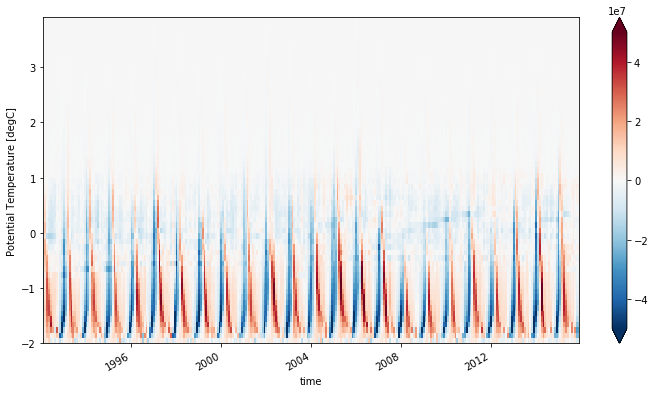

In [22]:
dVdt.plot(x='time', figsize=(12, 6), vmax=5e7)

## $\Omega_{total}$

In [26]:
omega_total = -histogram(ds.THETA.rename('theta').chunk({'i':-1}), bins=[theta_bins],
                         weights=ds.total_tendency_TH_truth.fillna(0.),
                         dim=['i', 'j', 'k']) / delta_theta

In [31]:
omega_total.load()

<xarray.DataArray 'histogram_theta' (time: 288, theta_bin: 59)>
array([[       -0.        ,        -0.        ,        -0.        , ...,
               -0.        ,        -0.        ,        -0.        ],
       [  2498695.7646066 ,  -1252584.30323146,  -5185913.32274809, ...,
               -0.        ,        -0.        ,        -0.        ],
       [  1356810.83122147,   3606710.03942311,   3388779.21865344, ...,
               -0.        ,        -0.        ,        -0.        ],
       ...,
       [   900872.86891088,  11938447.23325906,  27211905.78876394, ...,
               -0.        ,        -0.        ,        -0.        ],
       [ -2417410.18779832, -17067731.64495367, -36310164.93532807, ...,
               -0.        ,        -0.        ,        -0.        ],
       [       -0.        ,        -0.        ,        -0.        , ...,
               -0.        ,        -0.        ,        -0.        ]])
Coordinates:
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * theta_bin  (theta_bin) float64 -1.95 -1.85 -1.75 -1.65 ... 3.65 3.75 3.85

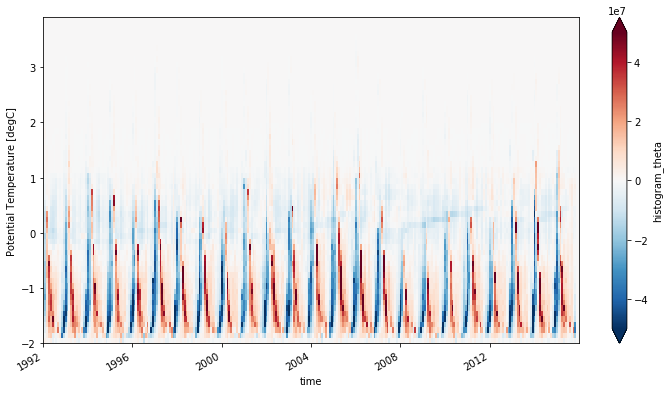

In [27]:
omega_total.plot(x='time', figsize=(12, 6), vmax=5e7)

## <font color='Green'>\begin{equation*} R1 = \frac{\partial \mathcal{V}}{\partial t} - \Omega_{total} \end{equation*} (Discretization of salt layers) </font>

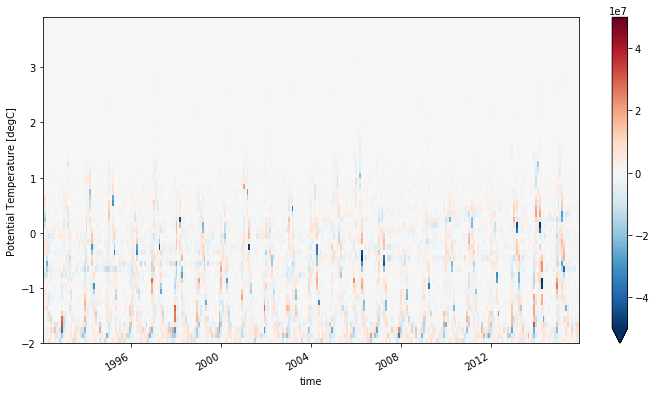

In [35]:
R1 = dVdt - omega_total[1:-1]
R1.plot(x='time', figsize=(12, 6), vmax=5e7)

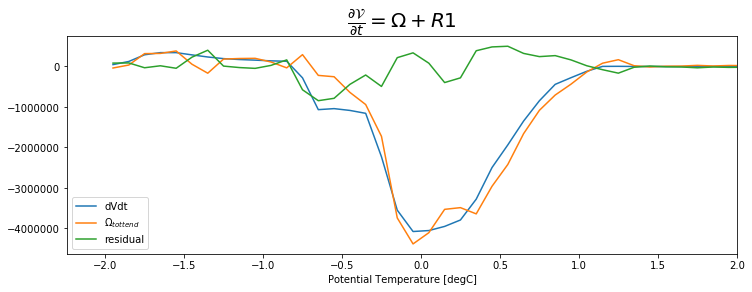

In [40]:
plt.figure(figsize=(12,4))
dVdt.mean(dim='time').plot(label='dVdt')
omega_total.mean(dim='time').plot(label=r'$\Omega_{tottend}$')
R1.mean(dim='time').plot(label='residual')
plt.legend()
plt.xlim(xmax=2)
plt.title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega + R1$', fontsize=20);

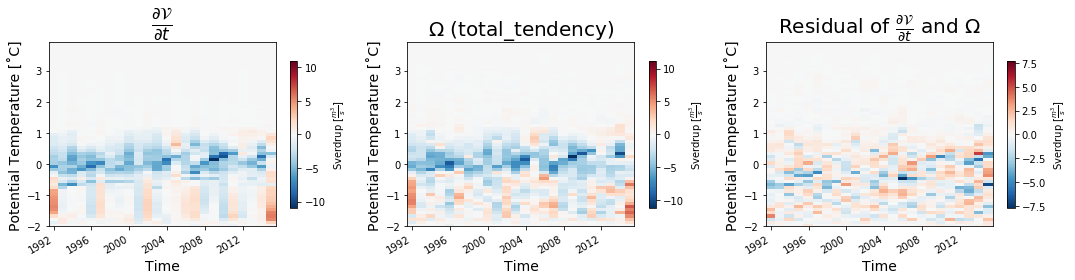

In [41]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

(dVdt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax0,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax0.set_ylabel('Potential Temperature [˚C]', fontsize=14)
ax0.set_xlabel('Time', fontsize=14)
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t}$', fontsize=24)

(omega_total[1:-1]/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax1, 
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax1.set_ylabel('Potential Temperature [˚C]', fontsize=14)
ax1.set_xlabel('Time', fontsize=14)
ax1.set_title('$\Omega$ (total_tendency)', fontsize=20)

(R1/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax2, 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax2.set_ylabel('Potential Temperature [˚C]', fontsize=14)
ax2.set_xlabel('Time', fontsize=14)
ax2.set_title(r'Residual of $\frac{\partial \mathcal{V}}{\partial t}$ and $\Omega$', fontsize=20)

plt.tight_layout();

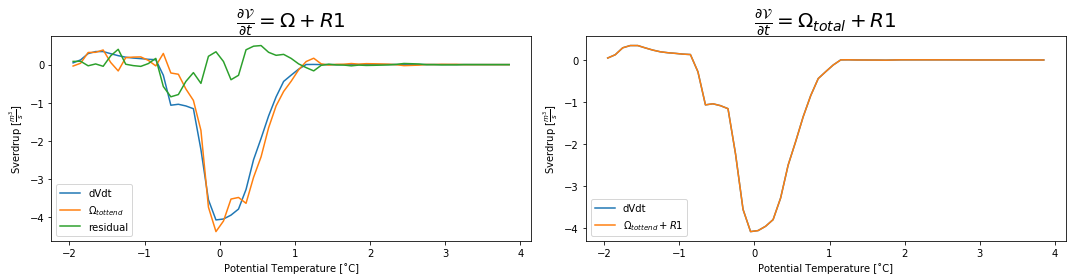

In [45]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=ax0)
(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=ax0)
(R1/1e6).mean(dim='time').plot(label='residual', ax=ax0)
ax0.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax0.set_xlabel('Potential Temperature [˚C]')
ax0.legend()
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega + R1$', fontsize=20)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=ax1)
((omega_total + R1)/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend} + R1$', ax=ax1)
ax1.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax1.set_xlabel('Potential Temperature [˚C]')
ax1.legend()
ax1.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$', fontsize=20)

plt.tight_layout();

## <span style='color:Green'> \begin{equation*} \Omega_{transformation-rate} \end{equation*}

In [54]:
def histogram_func(variable):
    """Generalized xhistogram's histogram function 
    for adv and diff flux terms"""
    hist = histogram(ds.THETA.rename('theta').chunk({'i':-1}), bins=[theta_bins],
                     weights=variable.fillna(0.), dim=['i', 'j', 'k'])
    return hist / delta_theta

In [55]:
all_tendencies = list(ds_tmp)
all_tendencies

['conv_horiz_adv_flux_TH',
 'conv_horiz_diff_flux_TH',
 'conv_vert_adv_flux_TH',
 'conv_vert_diff_flux_TH',
 'surface_flux_conv_TH',
 'sw_flux_conv_TH',
 'total_tendency_TH_truth']

In [56]:
all_dsets = xr.merge([histogram_func(ds_tmp[var]).rename('OMEGA_' + var)
                      for var in all_tendencies])
all_dsets

<xarray.Dataset>
Dimensions:                        (theta_bin: 59, time: 288)
Coordinates:
  * time                           (time) datetime64[ns] 1992-01-15 ... 2015-12-14
  * theta_bin                      (theta_bin) float64 -1.95 -1.85 ... 3.75 3.85
Data variables:
    OMEGA_conv_horiz_adv_flux_TH   (time, theta_bin) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    OMEGA_conv_horiz_diff_flux_TH  (time, theta_bin) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    OMEGA_conv_vert_adv_flux_TH    (time, theta_bin) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    OMEGA_conv_vert_diff_flux_TH   (time, theta_bin) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    OMEGA_surface_flux_conv_TH     (time, theta_bin) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    OMEGA_sw_flux_conv_TH          (time, theta_bin) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    OMEGA_total_tendency_TH_truth  (time, theta_bin) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>

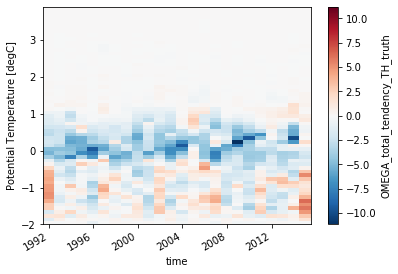

In [60]:
#checking to see if it looks the same as omega_total subplot above (and it does!)
(-all_dsets.OMEGA_total_tendency_TH_truth/1e6).resample(time='AS').mean(dim='time').plot(x='time')

In [62]:
omega_trans_rate = - (all_dsets.OMEGA_conv_horiz_diff_flux_TH + 
                      all_dsets.OMEGA_conv_vert_diff_flux_TH +
                      all_dsets.OMEGA_sw_flux_conv_TH + 
                      all_dsets.OMEGA_surface_flux_conv_TH)
omega_trans_rate.load()

<xarray.DataArray (time: 288, theta_bin: 59)>
array([[  -510212.9802525 ,  -6976130.7512936 , -15229294.35483515, ...,
               -0.        ,        -0.        ,        -0.        ],
       [  2409945.66590786,   -648354.33263525,  -4177476.78051434, ...,
               -0.        ,        -0.        ,        -0.        ],
       [   163631.0441488 ,   3572633.16201303,   4484636.89591644, ...,
               -0.        ,        -0.        ,        -0.        ],
       ...,
       [   806098.15007944,  11347848.99701025,  27303413.47410893, ...,
               -0.        ,        -0.        ,        -0.        ],
       [ -2526622.7114782 , -15705979.6051656 , -32921584.12541023, ...,
               -0.        ,        -0.        ,        -0.        ],
       [  -830548.71791439, -13668761.53492914, -33463705.31514266, ...,
               -0.        ,        -0.        ,        -0.        ]])
Coordinates:
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * theta_bin  (theta_bin) float64 -1.95 -1.85 -1.75 -1.65 ... 3.65 3.75 3.85

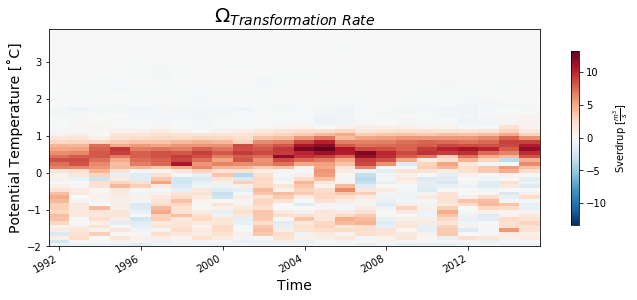

In [64]:
(omega_trans_rate.resample(time='AS').mean()/1e6).plot(x='time', figsize=(11,4), 
                                                       cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel('Potential Temperature [˚C]', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title(r'$\Omega_{Transformation\ Rate}$', fontsize=20);

## <font color='Green'> \begin{equation*} \Psi_{adv} = \Psi_{vel} + R2 \end{equation*} (Numerical Mixing) </font>

## $\Psi_{adv}$

In [65]:
psi_adv = -(all_dsets.OMEGA_conv_horiz_adv_flux_TH + all_dsets.OMEGA_conv_vert_adv_flux_TH)

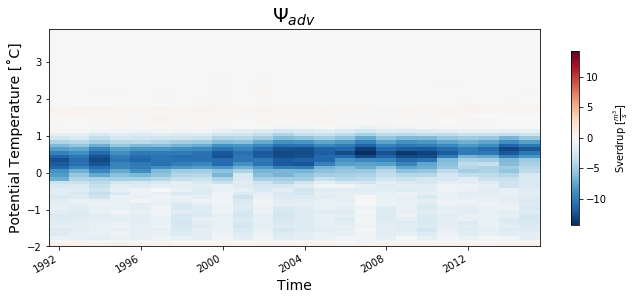

In [66]:
(psi_adv/1e6).resample(time='AS').mean(dim='time').plot(x='time', figsize=(11,4), 
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel('Potential Temperature [˚C]', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title(r'$\Psi_{adv}$', fontsize=20);

## $\Psi_{vel}$

In [74]:
#this is the "dA" part of the equation
u_transport_right = (ds.UVEL * coords.dyG * coords.drF).isel(i_g=-1) #m^3/s #(-) values -> westward, (+) values -> east
u_transport_left = (ds.UVEL * coords.dyG * coords.drF).isel(i_g=0)
v_transport = (ds.VVEL * coords.dxG * coords.drF).isel(j_g=-1) #m^3/s #(-) values -> south, (+) values -> north
w_transport = ds.WVEL.isel(k_l=0) * coords.rA #m^3/s #(-) values are massflux into the ocean, (+) values are massflux out of the ocean

In [83]:
u_transport_mean_value = (u_transport_right.sum(dim=['j', 'k']) -
                          u_transport_left.sum(dim=['j', 'k'])).mean(dim='time')/1e6
u_transport_mean_value.load()

<xarray.DataArray ()>
array(-38.406273, dtype=float32)

In [85]:
v_transport_mean_value = v_transport.mean(dim='time').sum()/1e6
v_transport_mean_value.load()

<xarray.DataArray ()>
array(38.4216, dtype=float32)

In [87]:
w_transport_mean_value = w_transport.mean(dim='time').sum()/1e6
w_transport_mean_value.load()

<xarray.DataArray ()>
array(-0.01507538, dtype=float32)
Coordinates:
    k_l      int64 0

In [88]:
residual = u_transport_mean_value + v_transport_mean_value + w_transport_mean_value
residual

<xarray.DataArray ()>
array(0.00025208, dtype=float32)
Coordinates:
    k_l      int64 0

In [92]:
# hack theta to be on same grid pt as velocity components
theta_at_u_right = ds.THETA.isel(i=-1)
theta_at_u_left = ds.THETA.isel(i=0)
theta_at_v = ds.THETA.isel(j=-1)
theta_at_w = ds.THETA.isel(k=0)

In [101]:
#this is the delta function part of the equation above
u_binned_right = histogram(theta_at_u_right.rename('theta'), bins=[theta_bins],
                     weights=u_transport_right, dim=['k', 'j'])
u_binned_left = histogram(theta_at_u_left.rename('theta'), bins=[theta_bins],
                     weights=u_transport_left, dim=['k', 'j'])
v_binned = histogram(theta_at_v.rename('theta'), bins=[theta_bins],
                     weights=v_transport, dim=['k', 'i'])
w_binned = histogram(theta_at_w.rename('theta'), bins=[theta_bins],
                     weights=w_transport, dim=['i', 'j'])

In [103]:
psi_vel = -(u_binned_right + u_binned_left + v_binned).cumsum(dim='theta_bin')

In [106]:
psi_vel.load()

<xarray.DataArray 'histogram_theta' (time: 288, theta_bin: 59)>
array([[       -0.        ,        -0.        ,     85116.85449219, ...,
        -30604726.66082716, -30604726.66082716, -30604726.66082716],
       [       -0.        ,        -0.        ,        -0.        , ...,
        -27805344.78760284, -27805344.78760284, -27805344.78760284],
       [       -0.        ,        -0.        ,        -0.        , ...,
        -32200995.03842318, -32200995.03842318, -32200995.03842318],
       ...,
       [       -0.        ,  -1156920.9921875 ,  -2394502.57438278, ...,
        -33500931.14900935, -33500931.14900935, -33500931.14900935],
       [       -0.        ,    182620.70584869,  -2919371.47412777, ...,
        -29893546.89956188, -29893546.89956188, -29893546.89956188],
       [       -0.        ,        -0.        ,    -80818.07821655, ...,
        -28088308.78935134, -28088308.78935134, -28088308.78935134]])
Coordinates:
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * theta_bin  (theta_bin) float64 -1.95 -1.85 -1.75 -1.65 ... 3.65 3.75 3.85

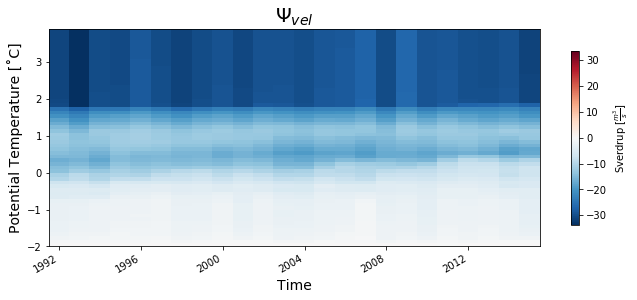

In [105]:
(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', figsize=(11,4), 
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel('Potential Temperature [˚C]', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('$\Psi_{vel}$', fontsize=20);

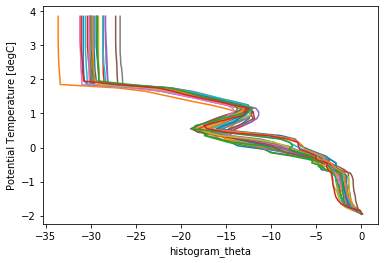

In [107]:
(psi_vel/1e6).resample(time='AS').mean(dim='time').plot.line(y='theta_bin', add_legend=False);

## R2 = $\Psi_{adv} - \Psi_{vel}$ (Numerical Mixing)

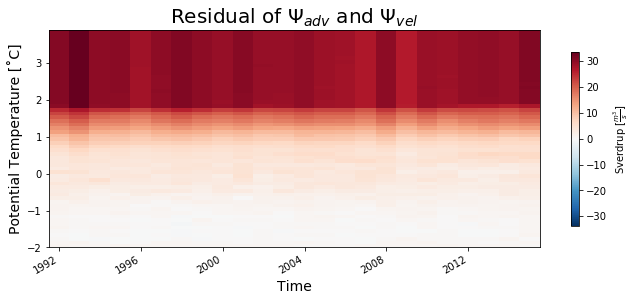

In [108]:
R2 = psi_adv - psi_vel
(R2/1e6).resample(time='AS').mean(dim='time').plot(x='time', figsize=(11,4), cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel('Potential Temperature [˚C]', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title(r'Residual of $\Psi_{adv}$ and $\Psi_{vel}$', fontsize=20);

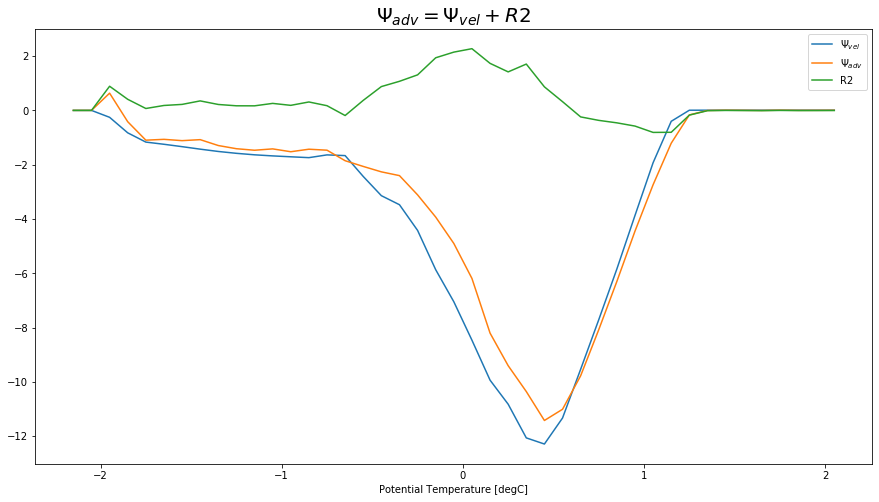

In [61]:
plt.figure(figsize=(15,8))
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$')
(psi_adv/1e6).mean(dim='time').plot(label='$\Psi_{adv}$')
(R2/1e6).mean(dim='time').plot(label='R2')
plt.title(r'$\Psi_{adv} = \Psi_{vel} + R2$', fontsize=20)
plt.legend();

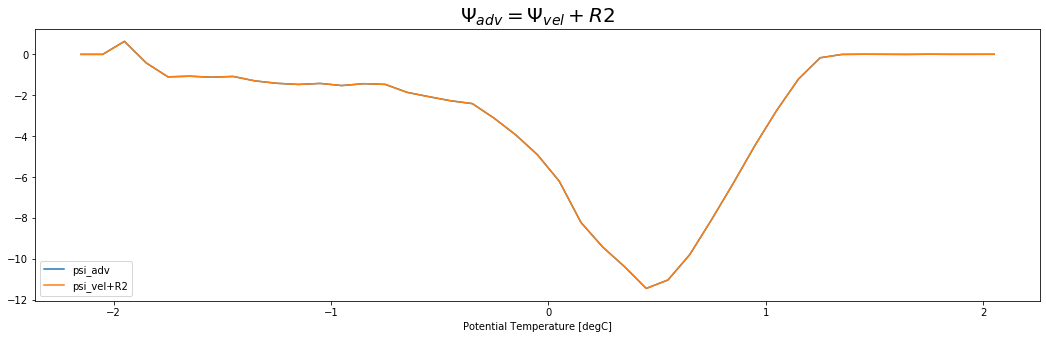

In [62]:
plt.figure(figsize=(18,5))
(psi_adv/1e6).mean(dim='time').plot(label='psi_adv')
((psi_vel+R2)/1e6).mean(dim='time').plot(label='psi_vel+R2')
plt.title(r'$\Psi_{adv} = \Psi_{vel} + R2$', fontsize=20, weight='bold')
plt.legend();

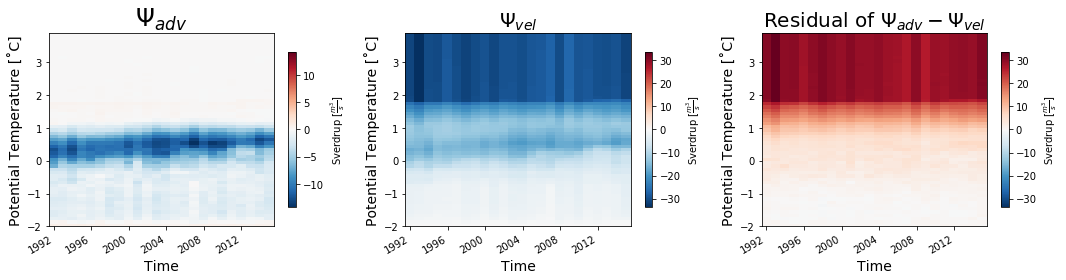

In [114]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

(psi_adv/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax0,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax0.set_ylabel('Potential Temperature [˚C]', fontsize=14)
ax0.set_xlabel('Time', fontsize=14)
ax0.set_title(r'$\Psi_{adv}$', fontsize=24)

(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax1, 
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax1.set_ylabel('Potential Temperature [˚C]', fontsize=14)
ax1.set_xlabel('Time', fontsize=14)
ax1.set_title('$\Psi_{vel}$', fontsize=20)

(R2/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax2, 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax2.set_ylabel('Potential Temperature [˚C]', fontsize=14)
ax2.set_xlabel('Time', fontsize=14)
ax2.set_title(r'Residual of $\Psi_{adv} - \Psi_{vel}$', fontsize=20)

plt.tight_layout();

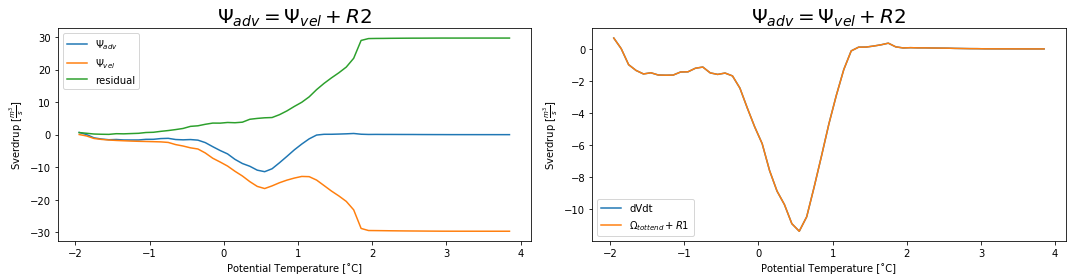

In [115]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

(psi_adv/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}$', ax=ax0)
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=ax0)
(R2/1e6).mean(dim='time').plot(label='residual', ax=ax0)
ax0.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax0.set_xlabel('Potential Temperature [˚C]')
ax0.legend()
ax0.set_title(r'$\Psi_{adv} = \Psi_{vel} + R2$', fontsize=20)

(psi_adv/1e6).mean(dim='time').plot(label='dVdt', ax=ax1)
((psi_vel + R2)/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend} + R1$', ax=ax1)
ax1.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax1.set_xlabel('Potential Temperature [˚C]')
ax1.legend()
ax1.set_title(r'$\Psi_{adv} = \Psi_{vel} + R2$', fontsize=20)

plt.tight_layout();

# dV/dt = $\Psi_{adv}$ + $\Omega_{trans-rate}$ + R1

In [50]:
dVdt.mean(dim='time')

<xarray.DataArray (theta_bin: 43)>
array([ 0.00000000e+00,  0.00000000e+00,  4.61830807e+04,  1.29110546e+05,
        2.16899605e+05,  2.28032922e+05,  2.21824326e+05,  1.84631459e+05,
        1.60014430e+05,  1.37418327e+05,  1.23290892e+05,  1.10595917e+05,
        9.42901204e+04,  8.38069003e+04, -1.58672281e+05, -5.79834579e+05,
       -6.77358536e+05, -7.56365996e+05, -8.09573473e+05, -1.54604584e+06,
       -2.52920781e+06, -2.90763656e+06, -2.78593023e+06, -2.70279375e+06,
       -2.60534767e+06, -2.29102097e+06, -1.87158076e+06, -1.54908593e+06,
       -1.13638596e+06, -6.96799895e+05, -3.22292163e+05, -1.93410223e+05,
       -7.29489871e+04,  6.27531547e+03,  4.38695904e+03,  3.14882214e+03,
        1.36045620e+03,  4.80789155e+02,  2.33731263e+02,  2.58839879e+02,
        2.45046573e+02,  3.26124498e+02,  2.92886534e+02])
Coordinates:
  * theta_bin  (theta_bin) float64 -2.15 -2.05 -1.95 -1.85 ... 1.85 1.95 2.05

In [51]:
omega_trans_rate[1:-1]

<xarray.DataArray (time: 286, theta_bin: 43)>
array([[      -0.        ,       -0.        ,  2409945.66590786, ...,
              -0.        ,       -0.        ,       -0.        ],
       [      -0.        ,       -0.        ,   163631.0441488 , ...,
              -0.        ,       -0.        ,       -0.        ],
       [      -0.        ,       -0.        ,  -111458.00116494, ...,
              -0.        ,       -0.        ,       -0.        ],
       ...,
       [      -0.        ,       -0.        , -2325388.99853983, ...,
              -0.        ,       -0.        ,       -0.        ],
       [      -0.        ,       -0.        ,   806098.15007944, ...,
              -0.        ,       -0.        ,       -0.        ],
       [      -0.        ,       -0.        , -2526622.7114782 , ...,
              -0.        ,       -0.        ,       -0.        ]])
Coordinates:
  * time       (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
  * theta_bin  (theta_bin) float64 -2.15 -2.05 -1.95 -1.85 ... 1.85 1.95 2.05

(2.2, -2.2)

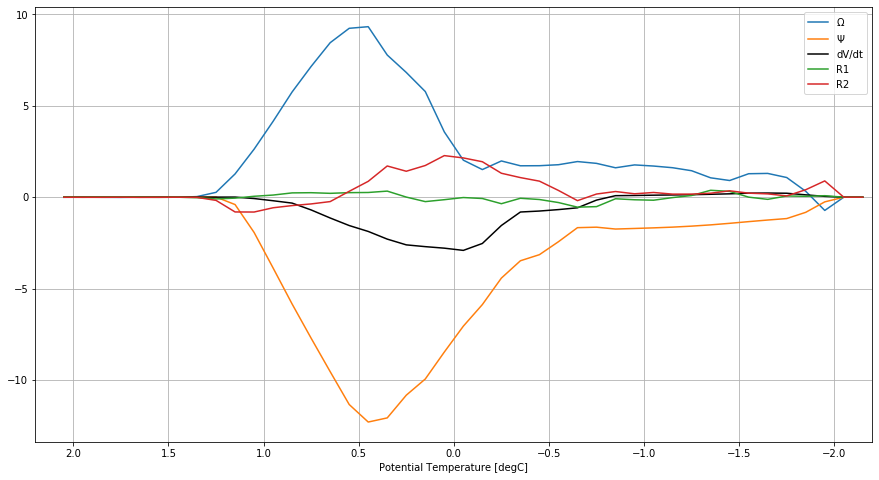

In [64]:
(omega_trans_rate[1:-1]/1e6).mean(dim='time').plot(figsize=(15,8), label=r'$\Omega$')
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$')
(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k')
(R1/1e6).mean(dim='time').plot(label='R1')
(R2/1e6).mean(dim='time').plot(label='R2')
plt.legend()
plt.grid()
plt.xlim(2.2, -2.2)

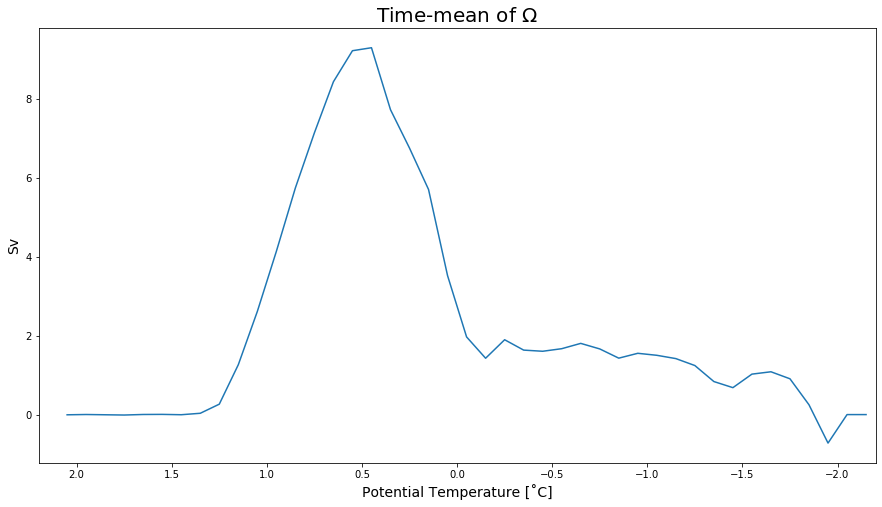

In [65]:
(omega_trans_rate/1e6).mean(dim='time').plot(figsize=(15,8))
plt.xlim(2.2,-2.2)
plt.ylabel('Sv', fontsize=14)
plt.xlabel('Potential Temperature [˚C]', fontsize=14)
plt.title(r'Time-mean of $\Omega$', fontsize=20);

### **Explanation:**
- If you have positive transformation in $\sigma$ bins, the water is getting lighter. So if you have positive transformation in $\theta$ bins, that means the water is getting warmer, no? And similarly, negative transformation in $\sigma$ bins means water is getting denser, so negative transformation in $\theta$ bins means water is getting colder.

(2, -2.5)

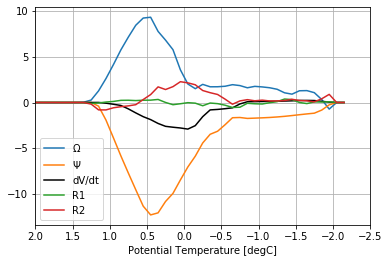

In [54]:
(omega_trans_rate[1:-1]/1e6).mean(dim='time').plot(label=r'$\Omega$')
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$')
(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k')
(R1/1e6).mean(dim='time').plot(label='R1')
(R2/1e6).mean(dim='time').plot(label='R2')
plt.legend()
plt.grid()
plt.xlim(2, -2.5)

In [66]:
omega_mix = -(all_dsets.OMEGA_conv_horiz_diff_flux_TH + 
                      all_dsets.OMEGA_conv_vert_diff_flux_TH)
omega_surf = - (all_dsets.OMEGA_sw_flux_conv_TH + 
                      all_dsets.OMEGA_surface_flux_conv_TH)

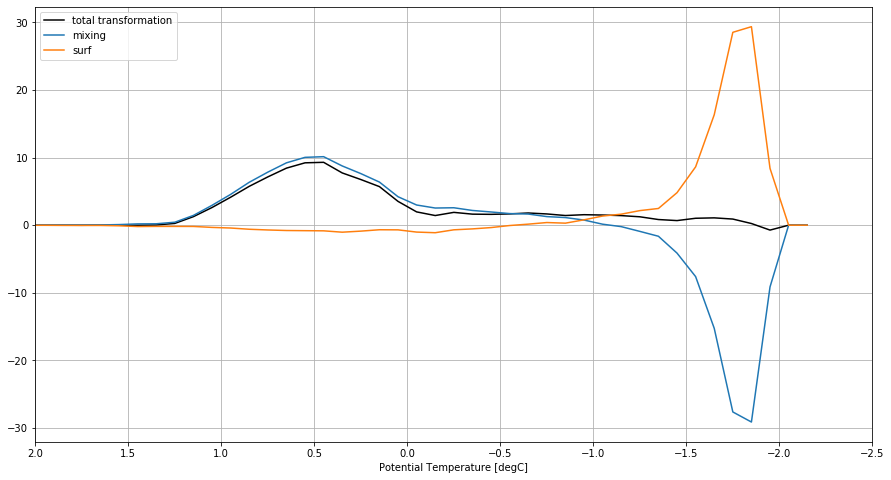

In [68]:
(omega_trans_rate/1e6).mean(dim='time').plot(figsize=(15,8), label='total transformation', color='k')
(omega_mix/1e6).mean(dim='time').plot(label='mixing')
(omega_surf/1e6).mean(dim='time').plot(label='surf')
plt.legend()
plt.grid()
plt.xlim(2, -2.5);

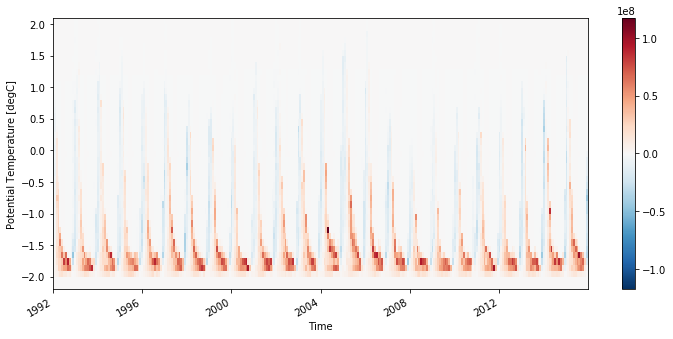

In [57]:
omega_surf.plot(x='time', figsize=(12, 5))

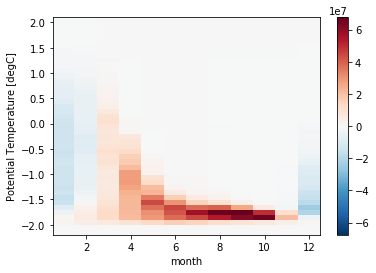

In [58]:
omega_surf.groupby('time.month').mean(dim='time').plot(x='month')

In [59]:
(R1/1e6).mean

<bound method ImplementsArrayReduce._reduce_method.<locals>.wrapped_func of <xarray.DataArray (time: 286, theta_bin: 43)>
array([[ 0.        ,  0.        ,  0.14311038, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  4.05253994, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  3.8559834 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        , -1.44983282, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  3.72293026, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , -5.96300039, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    time_snp   (time) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01
  * theta_bin  (theta_bin) float64 -2.15 -2.05 -1.95 -1.85 ... 1.85 1.95 2.05
  * time       (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14>

In [60]:
dVdt

<xarray.DataArray (time: 286, theta_bin: 43)>
array([[       0.        ,        0.        ,  2641806.14743295, ...,
               0.        ,        0.        ,        0.        ],
       [       0.        ,        0.        ,  5409350.76759857, ...,
               0.        ,        0.        ,        0.        ],
       [       0.        ,        0.        ,  4840173.94706173, ...,
               0.        ,        0.        ,        0.        ],
       ...,
       [       0.        ,        0.        , -3241520.41580247, ...,
               0.        ,        0.        ,        0.        ],
       [       0.        ,        0.        ,  4623803.1311828 , ...,
               0.        ,        0.        ,        0.        ],
       [       0.        ,        0.        , -8380410.57916049, ...,
               0.        ,        0.        ,        0.        ]])
Coordinates:
    time_snp   (time) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01
  * theta_bin  (theta_bin) float64 -2.15 -2.05 -1.95 -1.85 ... 1.85 1.95 2.05
  * time       (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

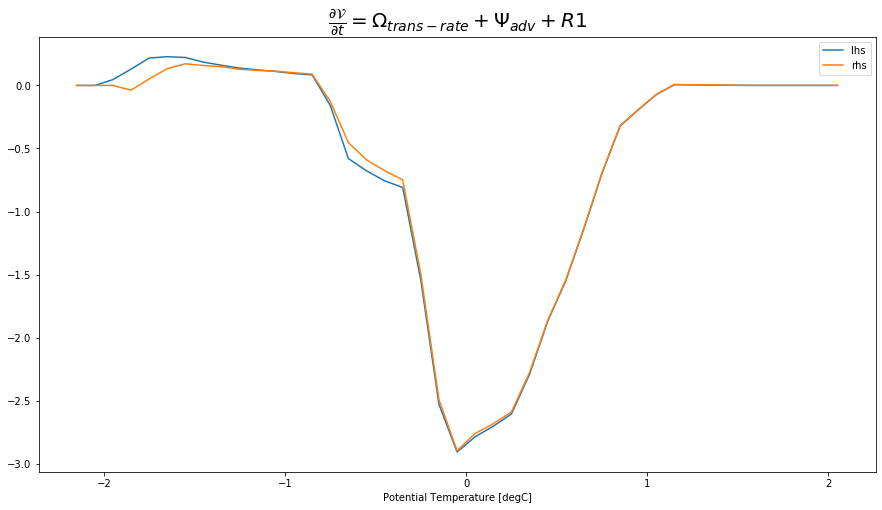

In [61]:
plt.figure(figsize=(15,8))
(dVdt/1e6).mean(dim='time').plot(label='lhs') 
((omega_trans_rate[1:-1] + R1 + psi_adv[1:-1])/1e6).mean(dim='time').plot(label='rhs')
plt.title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{trans-rate} + \Psi_{adv} + R1$', fontsize=20, fontweight='bold')
plt.legend();

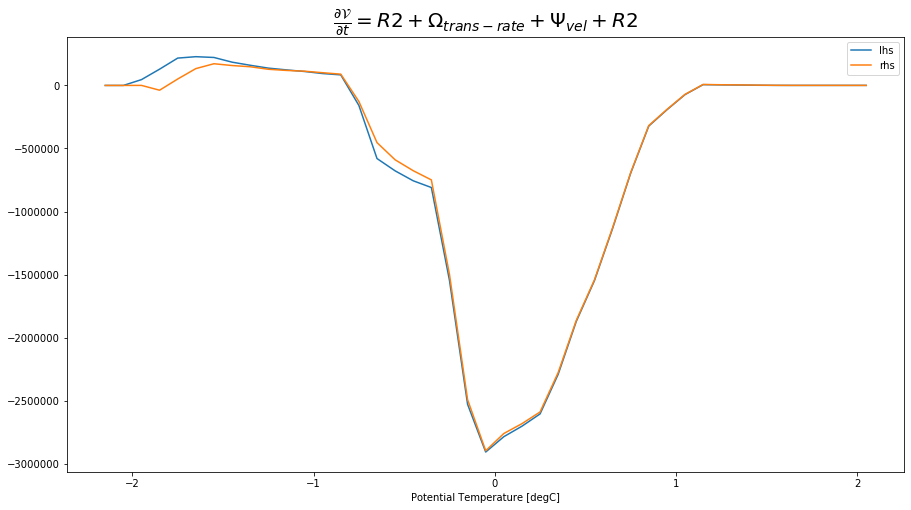

In [62]:
plt.figure(figsize=(15,8))
dVdt.mean(dim='time').plot(label='lhs') 
(omega_trans_rate + R1 + psi_vel + R2).mean(dim='time').plot(label='rhs')
plt.title(r'$\frac{\partial \mathcal{V}}{\partial t} = R2 + \Omega_{trans-rate} + \Psi_{vel} + R2$', fontsize=20, fontweight='bold')
plt.legend();

In [63]:
omega_total.isel(time=10)

<xarray.DataArray 'histogram_theta' (theta_bin: 43)>
array([-0.00000000e+00, -0.00000000e+00, -1.01296654e+06, -3.22870992e+07,
       -1.23736980e+07, -1.21057945e+07, -1.04554875e+07, -9.14540005e+06,
       -6.32156196e+06, -5.92489511e+06, -5.48200609e+06, -3.36655958e+06,
       -2.43819832e+06, -3.87638417e+06, -3.25009847e+06, -2.03698625e+06,
       -1.24258054e+06, -1.81197006e+06, -1.11717568e+06, -5.63399691e+05,
       -1.57041504e+06, -1.10571266e+05,  1.54162509e+06,  1.08126147e+06,
        1.41218777e+06,  7.68519499e+05,  5.13942041e+05,  1.35838675e+05,
       -1.66560507e+05, -1.56279436e+04, -3.30162789e+05, -6.42752059e+05,
       -1.06940838e+05, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00])
Coordinates:
    time       datetime64[ns] 1992-11-14
  * theta_bin  (theta_bin) float64 -2.15 -2.05 -1.95 -1.85 ... 1.85 1.95 2.05

In [64]:
psi_adv.isel(time=10)

<xarray.DataArray (theta_bin: 43)>
array([      -0.        ,       -0.        ,   150356.62985802,
       -2029558.91830921, -2256097.81980515, -3286392.78038025,
       -2368952.7381134 , -2231840.54042816, -1082507.00233459,
       -3297999.93228912, -4204898.11405182, -2442134.51457977,
        -884011.56803131, -3561325.2015686 , -3785912.64167786,
       -2639468.5861969 ,   303396.01768494, -3341119.58504677,
       -3068906.31599426, -1387212.58642197, -4089262.47416973,
       -3064755.8011961 , -8152779.84327376, -9719418.5220027 ,
       -9958523.49557877, -9706257.08065033, -8224466.51205063,
       -6880627.2454071 , -5759419.23215866, -4356075.51574707,
       -2927952.99087524, -1934426.27334595,  -658280.42236328,
             -0.        ,       -0.        ,       -0.        ,
             -0.        ,       -0.        ,       -0.        ,
             -0.        ,       -0.        ,       -0.        ,
             -0.        ])
Coordinates:
    time       datetime64[ns] 1992-11-14
  * theta_bin  (theta_bin) float64 -2.15 -2.05 -1.95 -1.85 ... 1.85 1.95 2.05

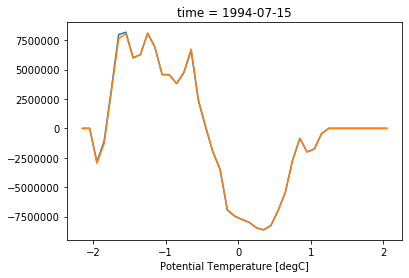

In [65]:
n = 30
omega_total.isel(time=n).plot()
(omega_trans_rate + psi_adv).isel(time=n).plot()


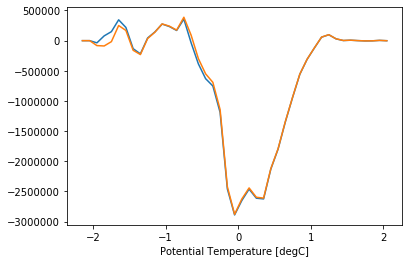

In [66]:
omega_total.isel(time=slice(1, -1)).mean(dim='time').plot()
(omega_trans_rate + psi_adv).isel(time=slice(1, -1)).mean(dim='time').plot()

In [67]:
omega_total.isel(time=0)

<xarray.DataArray 'histogram_theta' (theta_bin: 43)>
array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0.])
Coordinates:
    time       datetime64[ns] 1992-01-15
  * theta_bin  (theta_bin) float64 -2.15 -2.05 -1.95 -1.85 ... 1.85 1.95 2.05

In [68]:
omega_trans_rate[0]

<xarray.DataArray (theta_bin: 43)>
array([       -0.        ,        -0.        ,   -510212.9802525 ,
        -6976130.7512936 , -14132071.10075533, -17128222.01663338,
       -26479352.11414713, -26212936.91703171, -22315243.38655289,
       -23223025.56303626, -24149965.24834455, -26235447.46881109,
       -19245333.85727612, -16665603.1324308 , -13453169.06964973,
       -11712470.99684244, -11826644.39490107, -19049707.65341206,
       -13568310.56958628, -14703228.40300219, -15569150.10329664,
       -12086088.64181122,  -8596318.68312357,  -9012947.79940613,
        -5851638.37724961,   2113383.9685531 ,   4838733.84404045,
         6055479.35578644,   4612927.03356944,   3398720.9350282 ,
         1973668.72159615,   1254540.87556943,    223915.54509699,
              -0.        ,        -0.        ,        -0.        ,
              -0.        ,        -0.        ,        -0.        ,
              -0.        ,        -0.        ,        -0.        ,
              -0.        ])
Coordinates:
    time       datetime64[ns] 1992-01-15
  * theta_bin  (theta_bin) float64 -2.15 -2.05 -1.95 -1.85 ... 1.85 1.95 2.05